# Scenario 3: Agent-based Modeling with COmplexVID-19
This notebook is based on: https://github.com/scabini/COmplexVID-19/blob/master/run.py

### PART 1 
**TA1/TA2 model extraction and representation: ASKEM ABM representation**

### PART 2
**TA3 TASK 1:** Run COmplexVID-19 with the configuration for Brazil at the start of the COVID-19 pandemic, and recreate Fig. 4a (or a qualitatively similar scaled down version) for cases and deaths. 

Model source: https://doi.org/10.1016/j.physa.2020.125498 \
COmplexVID-19 code location: https://github.com/scabini/COmplexVID-19/tree/master

Specifications:
1. Run for 100,000 nodes/agents, with a scaling factor of 57, and 100 repetitions. (Feel free to adjust these values in light of runtime limitations.)
2. Use the age and family distributions from Table 1
3. Simulate for 300 days starting on February 26, 2020 (the date of the first confirmed case in Brazil)
4. Vary $\beta$ from 0.2 to 0.35 in increments of 0.05
5. Implement a moderate quarantine after 27 days (March 24, 2020), representing isolation measures
6. Question: *When do cases and deaths peak, and what are the levels of the peaks? Do these match Fig. 4a?*

<div>
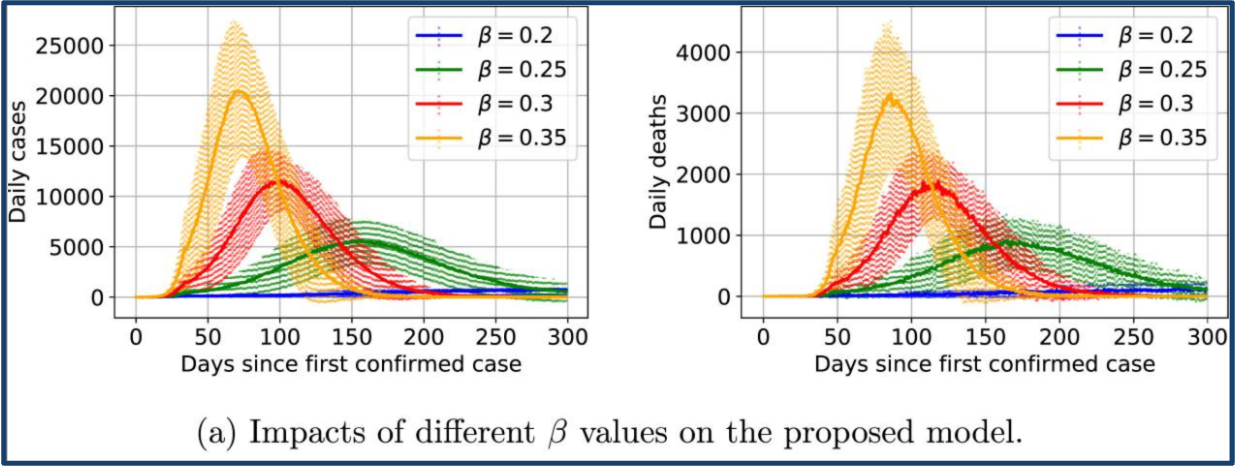
</div>

### PART 3 - Impact of chaging Brazilian population distribution
**(A) TA3 TASK 2:** Adjust the age distribution by:
1. Increasing the 60+ age group by 10%
2. Decreasing both the 0-13-year-old and 18-24-year old age groups by 5%

Run the model for 300 days starting on February 26, 2020 (keeping all other parameters the same as in Part 2).\
Question: *What is the impact of these changes to age distribution on infections, hospitalizations, and deaths?*

**(B) TA3 TASK 3:** Adjust the family size distribution using the values in the table below. 

Again, run the model for 300 days starting on February 26, 2020 (keeping all other parameters the same as in Part 2).\
Question: *What is the impact of these changes to age distribution on infections, hospitalizations, and deaths?*

<div>
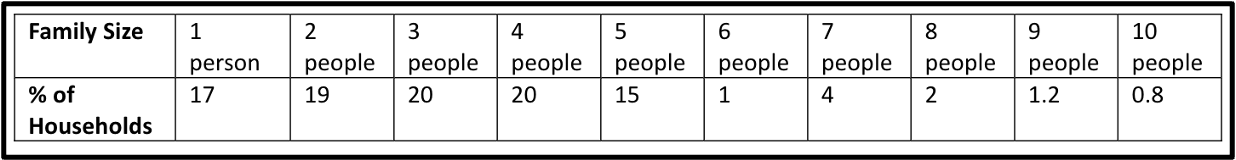
</div>

### Load dependencies, grab COmplexVID-19 files and functions

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

from multiprocessing import Pool
from collections import Counter
from time import perf_counter 

from pyciemss.utils.complexvid_scabini import comunities
from pyciemss.utils.complexvid_scabini import model
from pyciemss.utils.complexvid_scabini import dynamics_OTM

### Set up population size and distributions

In [ ]:
location = "Sao Carlos"
beta_global = 0.3 # baseline transmission rate with no intervention (best fit to Brazil data)
n = 100 # number of nodes, max 100K due to runtime, N * population_scale_factor = total_population
population_scale_factor = 57
repetitions = 10 # simulation repetitions, final results are averaged

days_to_simulate = 300
first_infection = "2020-02-26" # date of first infection
intervention_days = 27 # 2020-05-26, quarantine begins 27 days after first infection

# Age distribution, age_dist must sum to 1
age_dist = np.zeros((6))
age_dist[0] = 0.18 # 0-13  - school
age_dist[1] = 0.06 # 14-17 - school
age_dist[2] = 0.11 # 18-24 - work
age_dist[3] = 0.23 # 25-39 - work
age_dist[4] = 0.26 # 40-59 - work
age_dist[5] = 0.16 # 60+

# Distribution of family sizes, fam_structure must sum to 1
fam_structure = np.zeros((10))
fam_structure[0] = 0.12 # 1 person
fam_structure[1] = 0.22 # 2 people
fam_structure[2] = 0.25 # 3 people
fam_structure[3] = 0.21 # 4 people
fam_structure[4] = 0.11 # 5 people
fam_structure[5] = 0.05 # 6 people
fam_structure[6] = 0.02 # 7 people
fam_structure[7] = 0.01 # 8 people
fam_structure[8] = 0.005 # 9 people
fam_structure[9] = 0.005 # 10 people

# Church attendance and use of public transportation
qtde_religiao = 0.4 # fraction of the population that goes to church 1x/week
qtde_transporte =  0.36 # fraction of the population that uses public transportation
tempo_transporte = 1.2  # number of hours spent using public transportation per day

# Model layers
layer_names = ['casas', 'aleatorio', 'trabalho', 'transporte', 'escolas', 'igrejas'] # names of the layers: houses, random, work, transport, school, church
layers_0 = ['casas', 'aleatorio', 'trabalho', 'transporte', 'escolas', 'igrejas'] # initial model layers, assuming starting in SP quarantine, 4
layers_tirar = [["transporte", "escolas", "igrejas"], ["trabalho"]] # layers to remove in response to each action
layers_por = [[], []] # list of lists, layers to return for each action

### Model parameters

In [ ]:
parameters = dict(
seed=999666, # fixed seed for random operations
age_dist = age_dist,
fam_structure = fam_structure, #distribuicao de tamanhos de familias
tempo_transporte = tempo_transporte,
qtde_transporte = qtde_transporte,
qtde_religiao = qtde_religiao,
layers_0 = layers_0, #camadas iniciais do modelo
acoes = intervention_days,
layers_tirar = layers_tirar,
layers_por = layers_por,
n_nodes = n, #quantidade de pessoas usadas pra estimar as % da epidemia
#as probabilidade reais são dinamicas e dependem de varias coisas, que são
#definidas la dentro da criaçao das comunidades. Esse valor aqui é "quanto
#considerar desses valores: 0-> anula, 1-> original, 0.5-> metade, 2-> dobro
prob_home = beta_global,       #original> familia toda, 3hrs/dia. Cada camada removida aumenta a interação em casa em 25%
prob_random = beta_global,     #original> 1 proximo, 1hrs/semana, todos tem chance de ter de 1 a 10 conexoes aleatorias
prob_work = beta_global,       #original> 4 proximos/tamanho da empresa, 6hrs/dia, 5 dias/semana, todos de 18 a 59 anos.
prob_transport = beta_global,  #original> 5 proximos/tamanho do veiculo, 1.2hrs/dia, 50% da população (aleatoria)
prob_school = beta_global,     #original> 4 proximos/tamanho da sala, 5hrs/dia, 5 dias/semana, toda população de 0 a 17 anos
prob_religion = beta_global,   #original> 6 proximos/tamanho da igreja, 2hrs/semana, 40% da populaçao (aleatorio)
verbose=False       #printar ou nao as informações durante construção e simulação
)

In [ ]:
infected_t0 = 1 # initial infected population
home_isolation = 'home - total' #'total' ou 'partial', isola o vertice totalmente em casa (arestas de casa ficam), ou mantem tambem as aleatorias
hospital_isolation = 'hospital - total' #'total' ou 'partial', isola o vertice no hospital totalmente ou mantem os links aleatorios
                             #   que representam conexoes com pessoas do hospital

In [ ]:
def fun(data):
    return " ".join([item for var in data for item in var])

def analyze(i):
    parameters['seed'] = i
    np.random.seed(parameters['seed'])
    random.seed(parameters['seed'])
    count=[]
    G = model.createGraph(parameters)
    G, count = simulate(G, parameters, infected_t0=infected_t0, days=days, hospital_isolation=hospital_isolation, home_isolation=home_isolation)
    G = []
    count = np.true_divide(count, n)
    return count

In [ ]:
print("Home network: ", parameters['layers_0'])
print("Intervention dates: ", intervention_days)
print("Layers to insert: ", layers_por)
print("Layers to remove: ", layers_tirar)

index_list = [i for i in range(1, repetitions + 1)]
processes = os.cpu_count() - 2
pool = Pool(processes)
print('Running with', processes, 'threads')

In [ ]:
index_list = [i for i in range(1, repetitions + 1)]
processes = os.cpu_count() - 2
pool = Pool(processes)
print('Running with', processes, 'threads')

In [ ]:
count = []
t1_start = perf_counter()
result = pool.map(analyze, iterable=index_list, chunksize=None)
# result =analyze(1)

t1_stop = perf_counter()

In [ ]:




count = []
t1_start = perf_counter()
result = pool.map(analyze, iterable=index_list, chunksize=None)
# result =analyze(1)

t1_stop = perf_counter()
print("Spent ", t1_stop - t1_start, " seconds")

count = np.zeros((11, days, repetitions))
# count[:,:,0] = result
i = 0
for it in result:
    count[:, :, i] = it
    i += 1

In [ ]:
final = np.copy(count)
final3 = np.copy(count) * population_scale_factor

final = final[:, :, final3[0, days - 1, :] != n - 1]
final3 = np.copy(final) * population_scale_factor

count = np.mean(final, axis=2)  # average of iterations
std_mat = np.std(final, axis=2)  # standard deviation

final2 = np.copy(count)
count = count * population_scale_factor
std_mat = std_mat * population_scale_factor

total_casos = np.cumsum(final[5], axis=0) * population_scale_factor
std_und = np.std(total_casos, axis=1)
und_casos = np.mean(total_casos, axis=1)

total_casos = np.cumsum(final[6], axis=0) * population_scale_factor
std_diag = np.std(total_casos, axis=1)
diag_casos = np.mean(total_casos, axis=1)

total_casos = np.cumsum(final[8], axis=0) * population_scale_factor
recovered = np.mean(total_casos, axis=1)
std_recv = np.std(total_casos, axis=1)

In [ ]:
errorspace = 2
plt.figure(0)
plt.rcParams.update({'font.size': 15})

eb = plt.errorbar(range(0, days), und_casos, yerr=std_und, lw=2, color='red', label='undiagnosed',
                      errorevery=errorspace)
eb[-1][0].set_linewidth(1)

eb = plt.errorbar(range(0, days), diag_casos, yerr=std_diag, lw=2, color='orange', label='diagnosed',
                      errorevery=errorspace)
eb[-1][0].set_linewidth(1)

eb = plt.errorbar(range(0, days), recovered, yerr=std_recv, lw=2, alpha=0.65, color='green', label='recovered',
                      errorevery=errorspace)
eb[-1][0].set_linewidth(1)

In [ ]:
# plt.ylim(0, 5100000)
# plt.xlim([0,210])
plt.xlabel('Days since the first case')
plt.ylabel('Total cases')
ax = plt.gca()
# ax.yaxis.set_major_formatter(ticker.EngFormatter())

plt.xticks([0, acoes1[0], days],  ("0\n"+primeiro_infectado, str(acoes1[0]) + "\n" + acoes[0], str(days) +"\nDezembro 31"))

# plt.yticks([])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(path2 + "remove2_casos_total.pdf", dpi=500)

plt.figure(1)
plt.rcParams.update({'font.size': 15})

In [ ]:
train_start_date = "2021-12-01"
#start_date = date(2021, 12, 1)
test_start_date = "2022-03-01"
test_end_date = "2022-04-01"

test_dates = pd.date_range(start=train_start_date, end=test_end_date, freq="1D")
test_dates = [date.strftime("%Y-%m-%d") for date in test_dates[1:-1]]
print("train_start_date", train_start_date)

In [ ]:
test_dates